# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Veronika Jirmusová
xjirmu00

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [14]:
data = []

with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        if filename.endswith(".json"):
            with zf.open(filename, "r") as f:
                content = f.read().decode("utf-8")
                json_data = json.loads(content)
                data.append(json_data)  

df = pd.DataFrame(data)

df['configuration'] = df['configuration'].astype('string') #Lze pouzit i object
df['run'] = df['run'].astype('int')         
df['runtime'] = df['runtime'].astype('float') 
df['status'] = df['status'].astype('string') 

#Kontrola, ze je vse OK
print(df.head())
print(df.dtypes)  



  configuration  run     runtime   status
0       config6  149   53.733556  SUCCESS
1       config2   16  134.543496  SUCCESS
2       config6  180  117.108040  SUCCESS
3       config4   12  223.763044  SUCCESS
4       config5  193  159.540473  SUCCESS
configuration    string[python]
run                       int64
runtime                 float64
status           string[python]
dtype: object


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

               count        mean         std       min         25%  \
configuration                                                        
config1        200.0  123.104749  208.128584  0.000000   92.716828   
config2        200.0  167.456980  166.009023  0.000000  137.883249   
config3        200.0  144.151535  120.874132  0.000000  123.891821   
config4        200.0  143.054033  174.673555  0.000000   93.049865   
config5        200.0  198.904871  164.334180  0.000000  163.910896   
config6        200.0  118.870575  126.237033  2.124534   81.741231   

                      50%         75%     max  
configuration                                  
config1         99.799944  105.008525  1800.0  
config2        151.576787  165.004250  1800.0  
config3        138.038496  151.533715  1800.0  
config4        129.975246  165.023842  1800.0  
config5        183.916111  201.549486  1800.0  
config6        111.088189  137.889290  1800.0  


Identified outliers:
     configuration  run      run

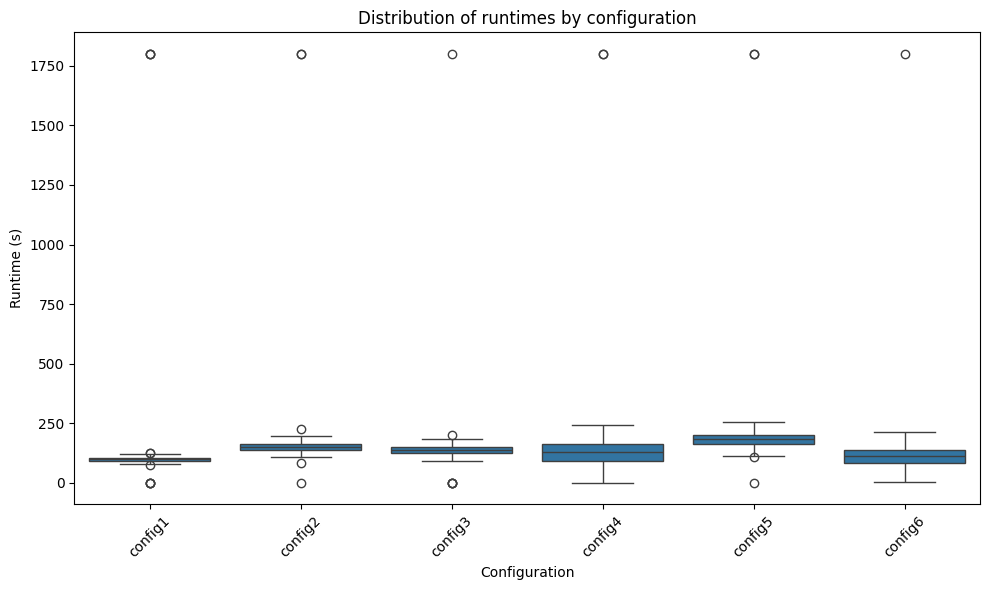

In [32]:
config_stats = df.groupby('configuration')['runtime'].describe()
print(config_stats)
print("\n")

# Tohle nevim, zda je nutne, ale mluvilo se o tom na prednasce, tak to inkluduji
def detect_outliers(data):
    Q1 = data.quantile(0.25)  
    Q3 = data.quantile(0.75)  # Prvni a treti kvantil
    IQR = Q3 - Q1 
    
    low = Q1 - 1.5 * IQR 
    upp = Q3 + 1.5 * IQR 

    return (data < low) | (data > upp)

df['outlier'] = df.groupby('configuration')['runtime'].transform(detect_outliers)

outliers = df[df['outlier']]
print("Identified outliers:")
print(outliers)

# Boxplot
config_order = ['config1', 'config2', 'config3', 'config4', 'config5', 'config6']
plt.figure(figsize=(10, 6))
sns.boxplot(x='configuration', y='runtime', data=df, order=config_order)
plt.title('Distribution of runtimes by configuration')
plt.ylabel('Runtime (s)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

Jak lze vidět výše, tak ano, chybné hodnoty (a outliers) se v databázi objevily. Jedná se o běhy, které neskončily úspěchem anebo o běhy, které mají až příliš vychýlenou hodnotu od průměrného běhu. Chyby mohou být různorodé, ale nejčastější chyba je chyba v implementaci algoritmu a v jeho nesprávném zacházení s přístupy do paměti - viz chyba segfault. Dále lze vidět, že se v některých případech algoritmus zacyklí nebo obsahuje jiné chyby, tedy nastane timeout, předčasné ukončení programu nebo vychýlené časové běhy. Jistě takové chyby mohly vzniknout i náhodně, tedy třeba vysokým zatížením systému nebo dostupností paměti, atd. 

Tento druh grafu jsem zvolila díky jeho vysoké přehlednosti při zobrazování vzájemných vztahů mezi chybnými hodnotami a zbytkem dat a poměrně jasně a zřetelně umí zobrazit data, která chceme mezi sebou porovnávat. Dále o něm velmi výrazně mluvil pan doktor na democvičení, takže jsem s ním byla nejvíce obeznámena a lépe se mi tedy i tvoří.


Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

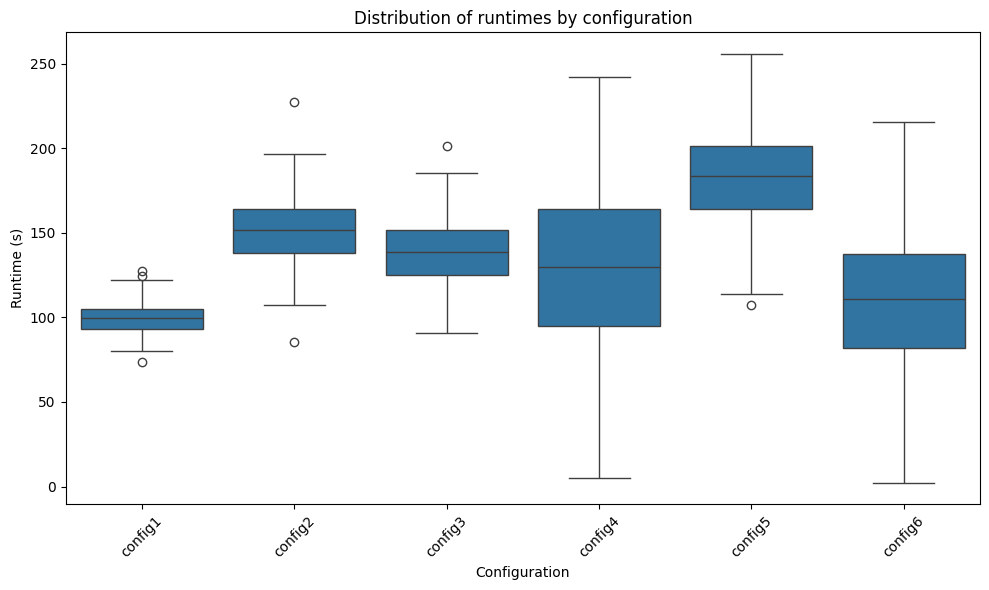

In [36]:
if (df['status'] == "SUCCESS").any():
    # Tady kopiruji svuj vlastni kod, tak snad to nebude povazovano za plagiat
    config_order = ['config1', 'config2', 'config3', 'config4', 'config5', 'config6']
    success = df[df['status'] == "SUCCESS"]
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='configuration', y='runtime', data=success, order=config_order)
    plt.title('Distribution of runtimes by configuration')
    plt.ylabel('Runtime (s)')
    plt.xlabel('Configuration')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [39]:
config_stats = df.groupby('configuration')['runtime'].describe()

print(config_stats)


               count        mean         std       min         25%  \
configuration                                                        
config1        200.0  123.104749  208.128584  0.000000   92.716828   
config2        200.0  167.456980  166.009023  0.000000  137.883249   
config3        200.0  144.151535  120.874132  0.000000  123.891821   
config4        200.0  143.054033  174.673555  0.000000   93.049865   
config5        200.0  198.904871  164.334180  0.000000  163.910896   
config6        200.0  118.870575  126.237033  2.124534   81.741231   

                      50%         75%     max  
configuration                                  
config1         99.799944  105.008525  1800.0  
config2        151.576787  165.004250  1800.0  
config3        138.038496  151.533715  1800.0  
config4        129.975246  165.023842  1800.0  
config5        183.916111  201.549486  1800.0  
config6        111.088189  137.889290  1800.0  


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

count: počet hodnot
mean: průměr
std: standardní odchylka
min: minimum
25%: 1. kvartil
50%: medián
75%: 3. kvartil
max: maximum

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

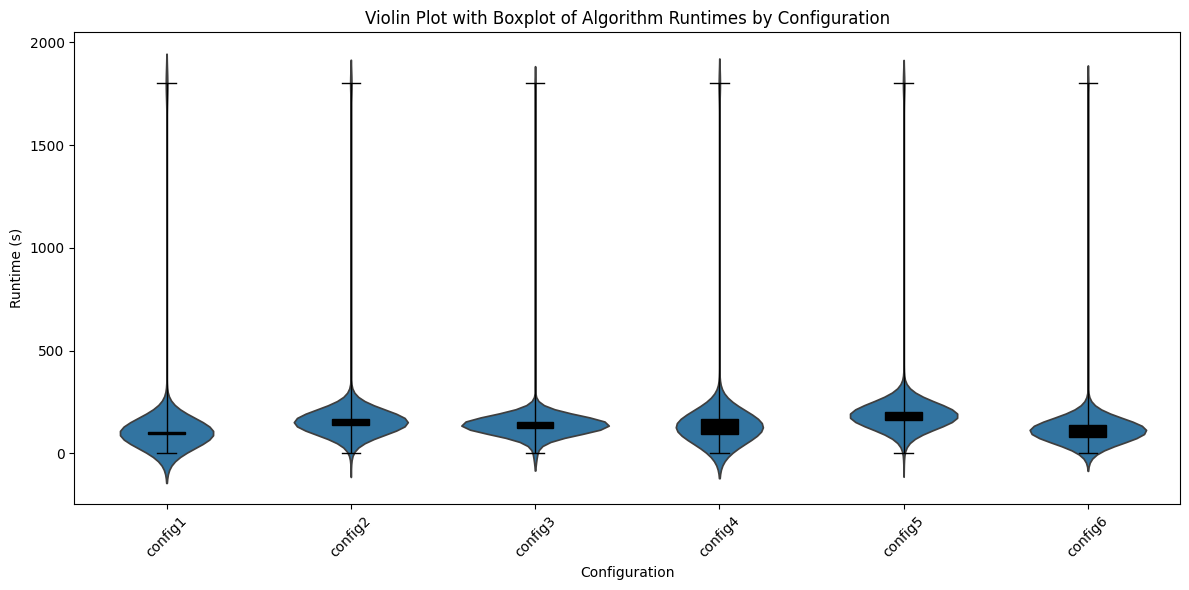

In [44]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='configuration', y='runtime', data=df, order=['config1', 'config2', 'config3', 'config4', 'config5', 'config6'], inner=None)
sns.boxplot(x='configuration', y='runtime', data=df, order=['config1', 'config2', 'config3', 'config4', 'config5', 'config6'], 
            whis=np.inf, color='k', width=0.2, fliersize=0)  # Boxplot without outliers
plt.title('Violin Plot with Boxplot of Algorithm Runtimes by Configuration')
plt.ylabel('Runtime (s)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()

# Zobrazení grafu
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

In [ ]:
# TODO: Implementace s využitím knihovní funkcí


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [32]:
# TODO vlastni implementace zvoleneho testu